In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from scipy import stats
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/w

In [3]:
import sys
sys.path.append('../src')
from data import fetch_model_data
from model import evaluation
%aimport data.fetch_model_data
%aimport model.evaluation

# EDA On Normal Set

In [4]:
metrics=['roc_auc', 'accuracy', 'precision']

## Load Data

In [5]:
ip_address = '18.223.109.72'
_, normal_data = fetch_model_data.fetch_model_data(ip_address, split=True)

In [6]:
first_feature_set = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
    'bipartisan',
    'ideol_range',
#     'first_word_approp',
]

In [7]:
X, y = normal_data[first_feature_set], normal_data.third_reading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# Basic Eda

In [8]:
normal_data.third_reading.value_counts()

1    721
0    132
Name: third_reading, dtype: int64

<BarContainer object of 2 artists>

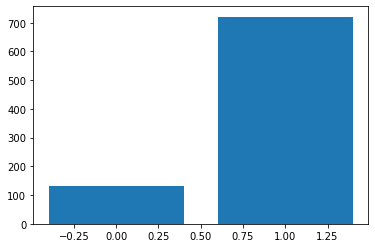

In [9]:
plt.bar([1, 0], normal_data.third_reading.value_counts())

In [10]:
normal_data.third_reading.value_counts()[1] / normal_data.shape[0]
# 85% of the data is class 1 (gets a third reading)

0.8452520515826495

In [11]:
by_author = normal_data.groupby('author_id').third_reading.agg(['sum', 'count']).reset_index()
by_author['perc_third'] = by_author['sum'] / by_author['count']

In [12]:
by_author.sort_values('perc_third')
# No crazy outliers


,author_id,sum,count,perc_third
52,17982,1,2,0.500000
32,12115,5,10,0.500000
7,1066,17,33,0.515152
15,1085,6,11,0.545455
40,14318,17,28,0.607143
9,1069,6,9,0.666667
35,14310,4,6,0.666667
12,1075,13,19,0.684211
33,13912,9,13,0.692308
30,11932,9,13,0.692308


# Histograms

In [13]:
def print_histograms(data, features, kde=True, y_lim=None):
    fig, ax = plt.subplots(nrows=len(features))

    fig.set_figheight(6*len(features))
    for a, col in zip(ax, features):
        
        sns.distplot(data[data.third_reading == 0][col], label='No', ax=a, kde=kde)
        sns.distplot(data[data.third_reading == 1][col], label='Yes', ax=a, kde=kde)       
        if y_lim:
            a.set_ylim([0, y_lim])
        a.set_title(col)
        a.legend()


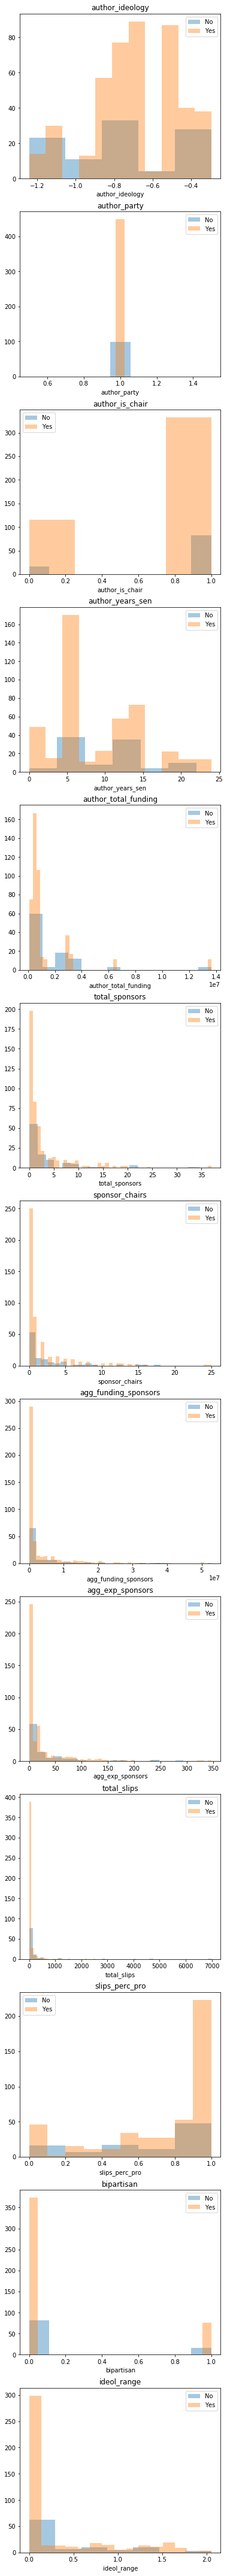

In [14]:
print_histograms(normal_data[normal_data.author_party == 1], first_feature_set, kde=False)

# With Oversampling

In [15]:
ros = RandomOverSampler(random_state=0)
normal_os, tr_os = ros.fit_sample(normal_data.drop(columns=['third_reading']), normal_data['third_reading'])
normal_os = pd.DataFrame(normal_os, columns=[x for x in normal_data.columns if x != 'third_reading'])
normal_os['third_reading'] = tr_os

In [16]:
normal_os.third_reading.value_counts()

1    721
0    721
Name: third_reading, dtype: int64

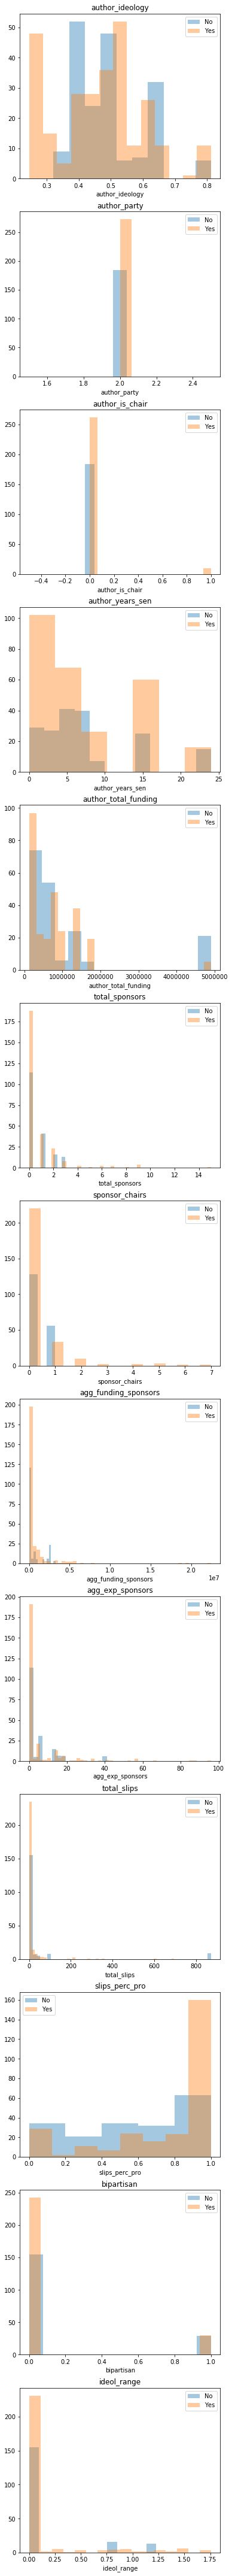

In [18]:
print_histograms(normal_os[normal_os.author_party == 2], first_feature_set, kde=False)

# New Features

## Risk Tolerance

In [19]:
fe = normal_os.copy()
fe = fe[fe.author_party == 1]

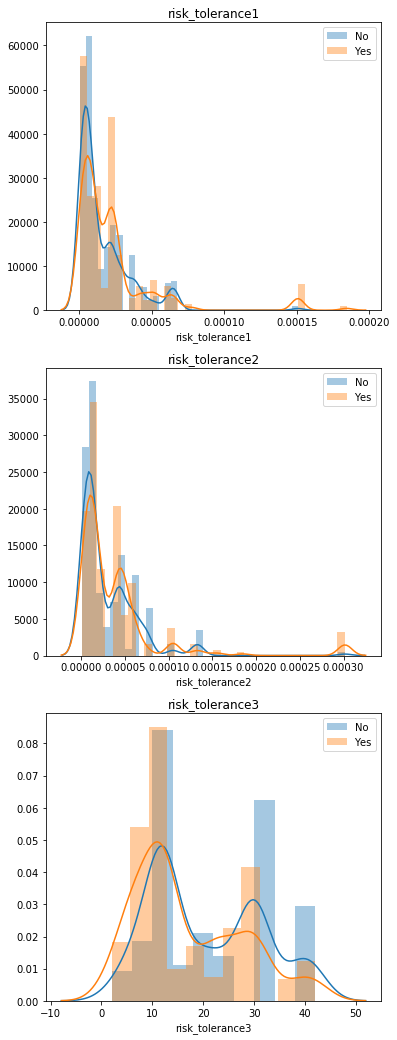

In [20]:
fe['risk_tolerance1'] = (fe.author_years_sen + 1) / fe.author_party / fe.author_total_funding
fe['risk_tolerance2'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1) / fe.author_party / fe.author_total_funding 
fe['risk_tolerance3'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1)
print_histograms(fe, ['risk_tolerance1', 'risk_tolerance2', 'risk_tolerance3'])

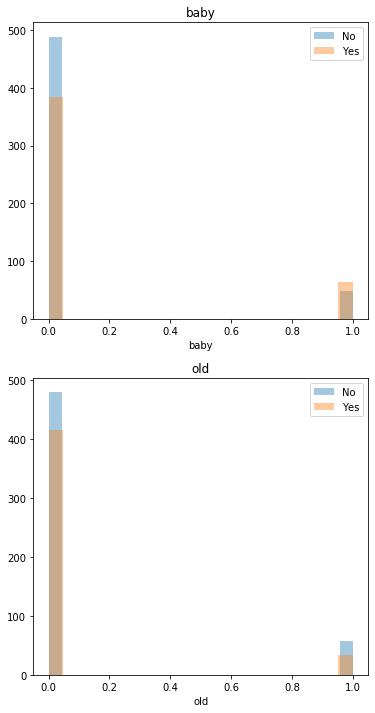

In [21]:
fe['baby'] = fe.author_years_sen.map(lambda x: 1 if x < 5 else 0)
fe['old'] = fe.author_years_sen.map(lambda x: 1 if x > 18 else 0)
print_histograms(fe, ['baby', 'old'], False)

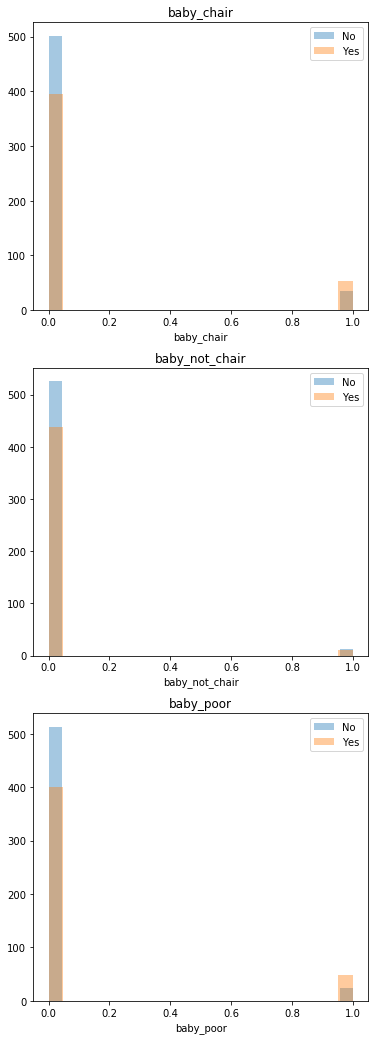

In [22]:
fe['baby_chair'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_is_chair > 0 else 0, axis=1)
fe['baby_not_chair'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_is_chair < 1 else 0, axis=1)
fe['baby_poor'] = fe.apply(lambda x: 1 if x.author_years_sen < 5 and x.author_total_funding < .2*10**7 else 0, axis=1)
print_histograms(fe, ['baby_chair', 'baby_not_chair', 'baby_poor'], False)

**Hard to make author data really separate bill success**

In [26]:
normal_os.author_party.value_counts()

1    986
2    456
Name: author_party, dtype: int64

# Non-Author Data

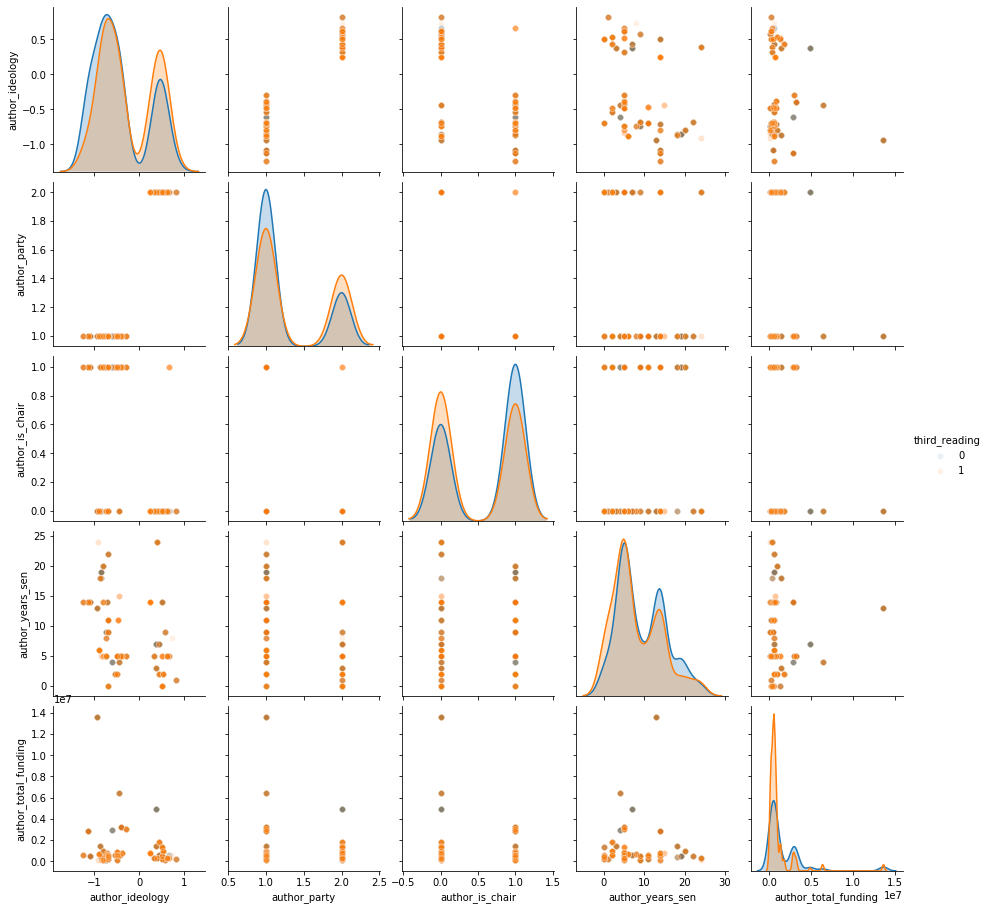

In [24]:
author_features = [
    'author_ideology',
    'author_party',
    'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'third_reading'
#     'total_sponsors',
#     'sponsor_chairs',
#     'agg_funding_sponsors',
#     'agg_exp_sponsors',
#     'total_slips',
#     'slips_perc_pro',
# #     'bipartisan',
#     'ideol_range',
]

sns.pairplot(normal_os[author_features], hue='third_reading', plot_kws={'alpha': 0.1})

In [ ]:
fe['nobody_cares'] = fe.apply(lambda x: 1 if x.total_slips <1 and x.total_sponsors < 1 else 0, axis=1)
fe['net_pro'] = (fe.slips_perc_pro * fe.total_slips) - ((1-fe.slips_perc_pro) * fe.total_slips)
print_histograms(fe, ['nobody_cares', 'net_pro'], kde=False, y_lim=100)
# net pro might be ok

# Standardize It

In [27]:
features_to_standardize = [
    'author_ideology',
#     'author_party',
#     'author_is_chair',
    'author_years_sen',
    'author_total_funding',
    'total_sponsors',
    'sponsor_chairs',
    'agg_funding_sponsors',
    'agg_exp_sponsors',
    'total_slips',
    'slips_perc_pro',
#     'bipartisan',
    'ideol_range',
]

norm_std = normal_data.copy()
norm_std.loc[:, features_to_standardize] = StandardScaler().fit_transform(normal_data[features_to_standardize])
norm_std = pd.DataFrame(norm_std, columns=first_feature_set)
norm_std['third_reading'] = normal_data.third_reading

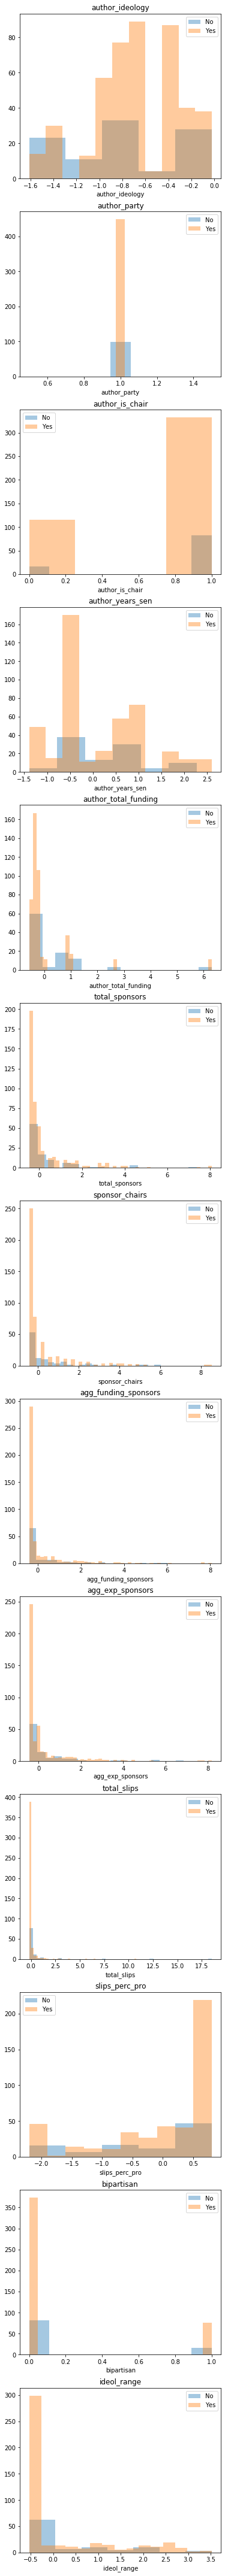

In [28]:
print_histograms(norm_std[norm_std.author_party == 1], first_feature_set, kde=False)

In [29]:
ros = RandomOverSampler(random_state=0)
std_os, std_os_y = ros.fit_sample(norm_std.drop(columns=['third_reading']), norm_std['third_reading'])
std_os = pd.DataFrame(normal_os, columns=[x for x in norm_std.columns if x != 'third_reading'])
std_os['third_reading'] = std_os_y

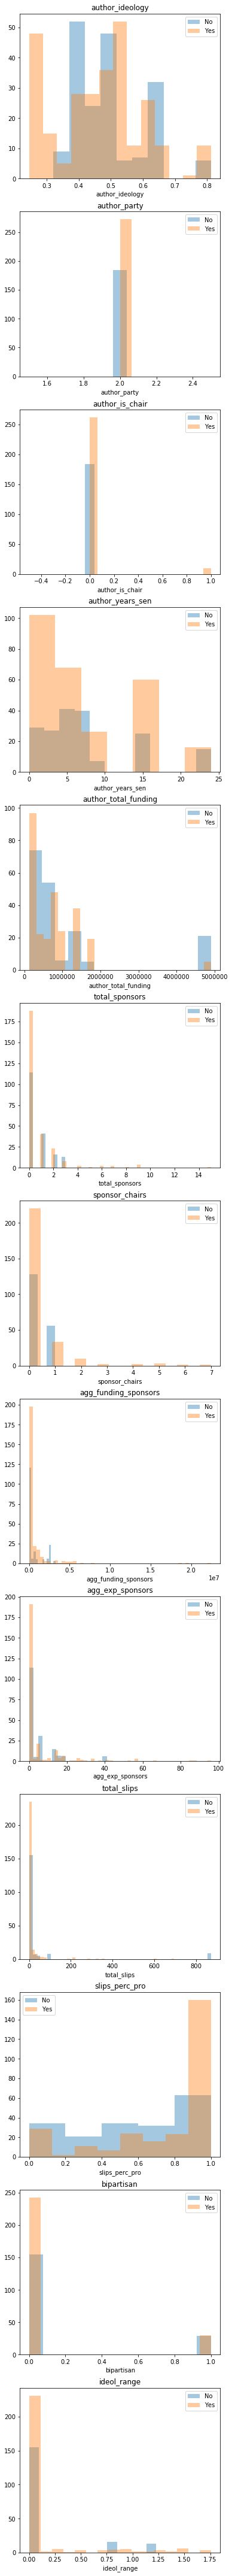

In [30]:
print_histograms(std_os[std_os.author_party == 2], first_feature_set, kde=False)

# What if I modeled the parties separately?

In [31]:
normal_data[normal_data.author_party == 2].shape

(305, 25)

# Features to Keep

In [32]:
fe['net_pro'] = (fe.slips_perc_pro * fe.total_slips) - ((1-fe.slips_perc_pro) * fe.total_slips)

In [33]:
fe['risk_tolerance3'] = (fe.author_years_sen + 1) * (fe.author_is_chair + 1)

In [34]:
fe['has_slips'] = fe.total_slips.map(lambda x: 1 if x > 0 else 0)

In [35]:
fe['unanimous_slips'] = fe.slips_perc_pro.map(lambda x: 1 if x > 0 else 0)

# Just Democrats

## Author Transformations

### Funding

In [36]:
dem_data = normal_os[normal_os.author_party == 1]

In [43]:
for col in ['author_total_funding', 'author_ideology', 'author_years_sen', 'total_sponsors', 'total_slips', 'slips_perc_pro', 'ideol_range']:
    dem_data[col] = dem_data[col].astype(float)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


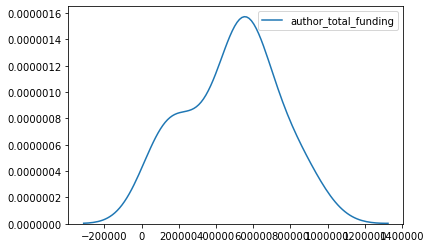

In [46]:
d = dem_data[(dem_data.author_total_funding < 1000000)].groupby('author_id').author_total_funding.agg('mean').reset_index()
sns.kdeplot(d.author_total_funding);
# plt.gca().set_xlim([0, 4000000])

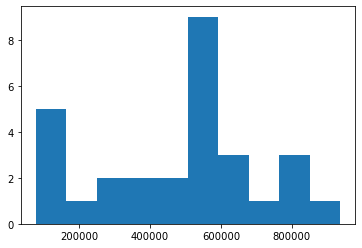

In [47]:
plt.hist(d.author_total_funding, bins=10);

In [48]:
# funding thresholds, < 400,000; < 1 mil, more than 1 mil
dem_data['funding_level'] = dem_data.author_total_funding.map(lambda x: 0 if float(x) < 400000 else 1 if x < 1000000 else 2)


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


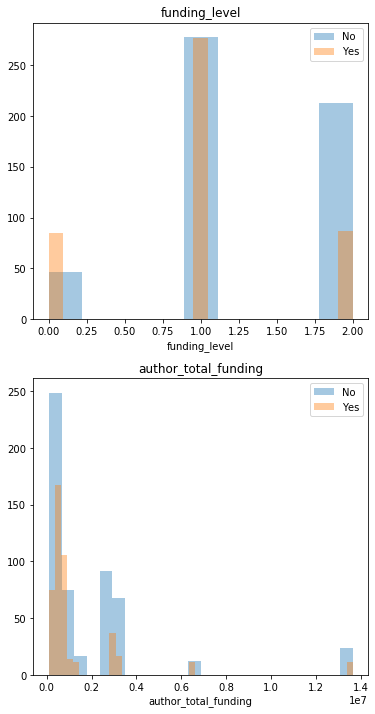

In [49]:
print_histograms(dem_data, ['funding_level', 'author_total_funding'], kde=False)

### Experience

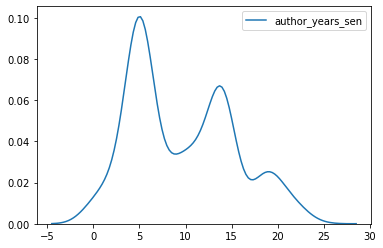

In [51]:
sns.kdeplot(dem_data.author_years_sen);

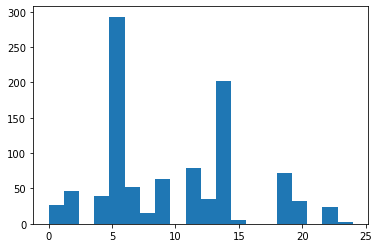

In [52]:
plt.hist(dem_data.author_years_sen, bins=20);

In [53]:
# sensible buckets -> less than 5, 5 to 10, 10 to 15, more than 15

In [56]:
dem_data['author_term'] = dem_data.author_years_sen.map(lambda x: 3 if (np.floor(x / 5) + 1) > 3 else np.floor(x / 5) + 1)
dem_data['num_terms'] = dem_data.author_years_sen.map(lambda x: np.floor(x / 4) if np.floor(x / 4) < 4 else 3)
# dem_data['first_term'] = dem_data.author_years_sen.map(lambda x: 1 if x < 4 else 0)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


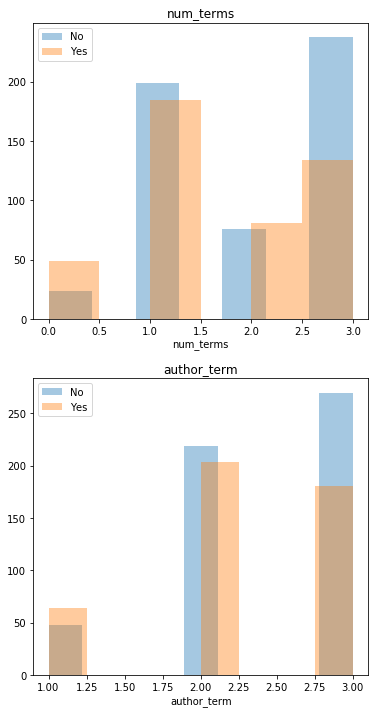

In [57]:
print_histograms(dem_data, ['num_terms', 'author_term'], kde=False)

### Ideology

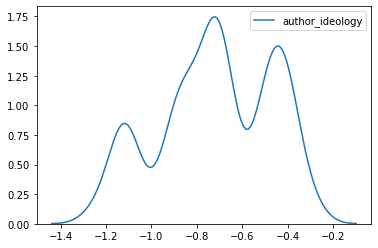

In [58]:
sns.kdeplot(dem_data.author_ideology);

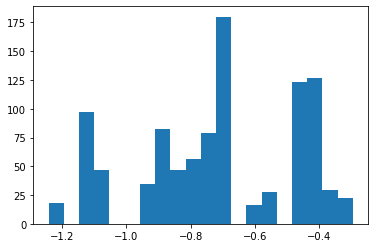

In [59]:
plt.hist(dem_data.author_ideology, bins=20);

In [60]:
dem_data.author_ideology = dem_data.author_ideology.astype(float)
dem_data['very_liberal'] = dem_data.author_ideology.map(lambda x: 1 if x < -1 else 0)


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


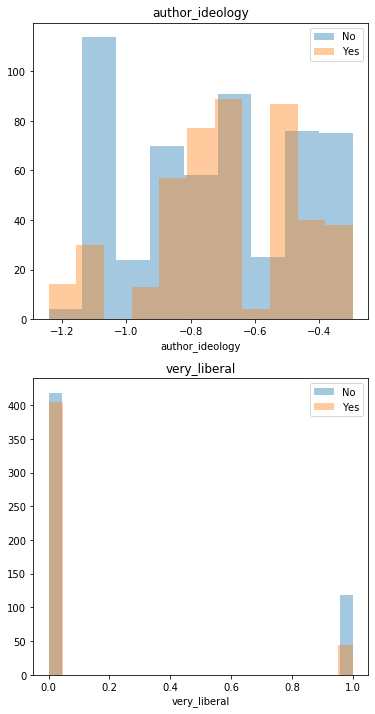

In [62]:
print_histograms(dem_data, ['author_ideology', 'very_liberal'], kde=False)